In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time

# Data

In [2]:
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import ToTensor, Compose
from torch.autograd import Variable

import os
import random
import datetime
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils.dataset import CutOrPad, get_rgb

In [3]:
PASTIS9 = './data/PASTIS9/'
PATH = PASTIS9
files = os.listdir(PATH)

In [4]:
file = random.choice(files)
data = pd.read_pickle(PATH + file)

print(data.keys())
print('Image: ', data['img'].shape)
print('Labels: ', data['labels'].shape, data['labels'])
print('DOY: ', data['doy'].shape, data['doy'])

dict_keys(['img', 'labels', 'doy'])
Image:  (46, 10, 9, 9)
Labels:  () 1.0
DOY:  (46,) [  3  28  43  48  53  58  78  83  88 103 108 123 133 143 153 158 163 168
 178 183 188 193 198 203 213 223 233 238 243 248 253 258 263 263 273 273
 278 283 288 293 298 308 313 328 343 353]


In [5]:
class PASTIS(Dataset):
    def __init__(self, pastis_path):
        self.pastis_path = pastis_path

        self.file_names = os.listdir(self.pastis_path)[:500]

        random.shuffle(self.file_names)

        self.to_cutorpad = CutOrPad()
        # self.to_tiledates = TileDates(24, 24)
        # self.to_unkmask = UnkMask(unk_class=19, ground_truth_target='labels'))



    def __len__(self):
        return len(self.file_names)


    def add_date_channel(self, img, doy):
        img = torch.cat((img, doy), dim=1)
        return img


    def normalize(self, img):
        C = img.shape[1]
        mean = img.mean(dim=(0, 2, 3)).to(torch.float32).reshape(1, C, 1, 1)
        std = img.std(dim=(0, 2, 3)).to(torch.float32).reshape(1, C, 1, 1)

        img = (img - mean) / std

        return img


    def __getitem__(self, idx):
        data = pd.read_pickle(os.path.join(self.pastis_path, self.file_names[idx]))

        data['img'] = data['img'].astype('float32')
        data['img'] = torch.tensor(data['img'])
        data['img'] = self.normalize(data['img'])
        T, C, H, W = data['img'].shape

        data['labels'] = data['labels'].astype('long')
        data['labels'] = torch.tensor(data['labels'])
        # data['labels'] = F.one_hot(data['labels'].long(), num_classes=20)

        data['doy'] = data['doy'].astype('float32')
        data['doy'] = torch.tensor(data['doy'])
        data['doy'] = data['doy'].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        data['doy'] = data['doy'].repeat(1, 1, H, W)

        data['img'] = self.add_date_channel(data['img'], data['doy']) # add DOY to the last channel
        del data['doy'] # Delete DOY

        data = self.to_cutorpad(data) # Pad to Max Sequence Length
        del data['seq_lengths'] # Delete Sequence Length


        return data['img'], data['labels']

In [6]:
data = PASTIS(PATH)
data.__len__()

500

In [7]:
data.__len__()

500

In [8]:
train_set, val_set = random_split(data, [400, 100])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=True)

tensor([0])


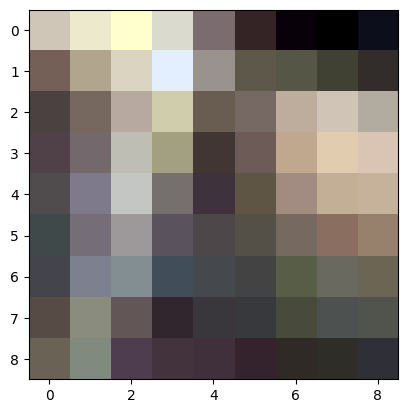

In [9]:
img, label = next(iter(train_loader))
plt.imshow(get_rgb(img[0][:,:-1,:,:].numpy()))
print(label[0].unique())

# Network

In [10]:
from torch import nn, einsum
from einops import rearrange
from einops.layers.torch import Rearrange



class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)



class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # print(x.shape)
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        # print(q.shape, k.shape, v.shape)
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out



class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

In [11]:
class Classification(nn.Module):
    def __init__(self, img_height=9, img_width=9, in_channel=10,
                       patch_size=3, embed_dim=128, max_time=60,
                       num_classes=20, num_head=4, dim_feedforward=2048,
                       num_layers=4
                ):
        super().__init__()
        
        self.H = img_height
        self.W = img_width
        self.P = patch_size
        self.C = in_channel
        self.d = embed_dim
        self.T = max_time
        self.K = num_classes

        self.d_model = self.d
        self.num_head = num_head
        self.dim_feedforward = self.d
        self.num_layers = num_layers

        self.N = int(self.H * self.W // self.P**2)
        self.nh = int(self.H / self.P)
        self.nw = int(self.W / self.P)


        '''
        PARAMETERS
        '''
        # Transformer Encoder

        # PyTorch Encoder
        # self.encoderLayer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.num_head, dim_feedforward=self.dim_feedforward)
        # self.encoder = nn.TransformerEncoder(self.encoderLayer, num_layers=self.num_layers)

        # DeepSat Encoder
        self.encoder = Transformer(self.d, self.num_layers, self.num_head, 32, self.d*4)


        # torchvision Encoder
        # self.encoder = Encoder(seq_length=self.N, num_heads=4, num_layers=4, hidden_dim=self.d, mlp_dim=self.d*4, dropout=0., attention_dropout=0.)


        # Patches
        self.projection = nn.Conv3d(self.C, self.d, kernel_size=(1, self.P, self.P), stride=(1, self.P, self.P))
        '''
        def __init__():
            self.linear = nn.Linear(self.C*self.P**2, self.d)
        def forward():
            x = x.view(B, T, H // P, W // P, C*P**2)
            x = self.linear(x)
        '''

        # Temporal
        self.temporal_emb = nn.Linear(366, self.d)
        self.temporal_cls_token = nn.Parameter(torch.randn(1, self.N, self.K, self.d)) # (N, K, d)
        self.temporal_transformer = self.encoder

        # Spatial
        self.spatial_emb = nn.Parameter(torch.randn(1, self.N, self.d)) # (1, N, d)
        self.spatial_cls_token = nn.Parameter(torch.randn(1, self.K, self.d)) # (1, K, d)
        self.spatial_transformer = self.encoder

        # Segmentation Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.d),
            nn.Linear(self.d, 1)
            )



    def forward(self, x):
        '''
        Tekenization

        Convert the images to a sequence of patches
        '''
        x_sits = x[:, :, :-1, :, :] # (B, T, C, H, W) -- > Exclude DOY Channel
        B, T, C, H, W = x_sits.shape # (B, T, C, H, W)
        x_sits = x_sits.reshape(B, C, T, H, W) # (B, C, T, H, W)
        x_sits = self.projection(x_sits) # (B, d, T, nw, nh)
        x_sits = x_sits.reshape(B, self.d, T, self.nh*self.nw) # (B, d, T, N)
        # x_sits = x_sits + self.pos_emb # (B, d, T, N)  we dont add pos embedding here, cuz we need the pure data for the temporal encoder
        x_sits = x_sits.permute(0,3,2,1) # (B, N, T, d)



        '''
        Temporal Encoding

        (DOY -> One-Hot -> Projection)
        '''
        xt = x[:, :, -1, 0, 0] # (B, T, C, H, W) in the last channel lies the DOY feature
        xt = F.one_hot(xt.to(torch.int64), num_classes=366).to(torch.float32) # (B, T, 366)
        Pt = self.temporal_emb(xt) # (B, T, d) (DOY, one-hot encoded to represent the DOY feature and then encoded to d dimensions)




        '''
        Temporal Encoder: cat(Z+Pt)

        add temporal embeddings (N*K) to the Time Series patches (T)
        '''
        x = x_sits + Pt.unsqueeze(1) # (B, N, T, d)
        temporal_cls_token = self.temporal_cls_token # (1, N, K, d)
        temporal_cls_token = temporal_cls_token.repeat(B, 1, 1, 1) # (B, N, K, d)
        temporal_cls_token = temporal_cls_token.reshape(B*self.N, self.K, self.d) # (B*N, K, d)
        x = x.reshape(B*self.N, T, self.d) # (B*N, T, d)
        # Temporal Tokens (N*K)
        x = torch.cat([temporal_cls_token, x], dim=1) # (B*N, K+T, d)
        # Temporal Transformer
        x = self.temporal_transformer(x) # (B*N, K+T, d)
        x = x.reshape(B, self.N, self.K + T, self.d) # (B, N, K+T, d)
        x = x[:,:,:self.K,:] # (B, N, K, d)
        x = x.permute(0, 2, 1, 3) # (B, K, N, d)
        x = x.reshape(B*(self.K), self.N, self.d) # (B*K, N, d)




        '''
        Spatial Encoding
        '''
        Ps = self.spatial_emb # (1, N, d)
        x = x + Ps # (B*K, N, d)
        # For Classification Only
        spatial_cls_token = self.spatial_cls_token # (1, K, d)
        spatial_cls_token = spatial_cls_token.unsqueeze(2) # (1, K, 1, d)
        spatial_cls_token = spatial_cls_token.repeat(B, 1, 1, 1) # (B, K, 1, d)
        spatial_cls_token = spatial_cls_token.reshape(B*self.K, 1, self.d) # (B*K, 1, d)
        x = torch.cat([spatial_cls_token, x], dim=1) # (B*K, 1+N, d)
        x = self.spatial_transformer(x) # (B*K, N+1, d)



        '''
        Classification Head
        '''
        classes = x[:,0,:] # (B*K, d)
        classes = classes.reshape(B, self.K, self.d) # (B, K, d)
        
        x = self.mlp_head(classes) # (B, K, 1)
        x = x.reshape(B, self.K) # (B, K)



        return x

# Training

### Loss Function

In [12]:
class FocalLoss(nn.Module):
    """
    Credits to  github.com/clcarwin/focal_loss_pytorch
    """
    def __init__(self, gamma=8, alpha=torch.ones(20), reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.reduction = reduction
        
    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction is None:
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            raise ValueError(
                "FocalLoss: reduction parameter not in list of acceptable values [\"mean\", \"sum\", None]")

## Train

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Data
batch_size = 8

# Model
model = Classification(img_width=9, img_height=9, in_channel=10, patch_size=3, embed_dim=128, max_time=60, num_head=4, num_layers=4, num_classes=20)
model.to(device)

num_samples = train_loader.__len__()*batch_size

num_params = sum([p.numel() for p in model.parameters() if p.requires_grad == True])
print('Number of Parameters: ', num_params)

# Loss
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
# criterion = nn.MSELoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.AdamW(model.parameters(), lr=0.01)
epochs = 200
model.train()

Number of Parameters:  877569


Classification(
  (encoder): Transformer(
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=384, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=512, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=512, out_features=128, bias=True)
              (4): Dropout(p=0.0, inplace=False)
            )
          )
        )
      )
    )
    (norm): LayerNorm((12

## Trainer

### Basic

In [14]:
from tqdm import tqdm
for epoch in range(epochs):
  epoch_loss = 0

  t1 = time.time()
  for batch in tqdm(train_loader):
    img, label = batch
    img, label = img.to(device), label.to(device)


    optimizer.zero_grad()
    
    output = model(img)
    
    # print(f'Output shape: {output.shape} | Label shape: {label.shape}')
    # print('Output: ', output[0], 'Label: ', label[0])

    loss = criterion(output, label)
    epoch_loss += loss

    loss.backward()
    optimizer.step()


  if epoch % 10 == 0:
    torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, f'./weights/cls_epoch_{epoch}.pt')
  t2 = time.time()
  print('Epoch: ', epoch, 'Loss: ', (epoch_loss/num_samples)*100)

100%|██████████| 50/50 [00:01<00:00, 25.92it/s]


Epoch:  0 Loss:  tensor(12.9140, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.43it/s]


Epoch:  1 Loss:  tensor(10.8758, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.47it/s]


Epoch:  2 Loss:  tensor(10.8166, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 43.42it/s]


Epoch:  3 Loss:  tensor(10.4740, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.76it/s]


Epoch:  4 Loss:  tensor(10.5409, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.81it/s]


Epoch:  5 Loss:  tensor(10.1680, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 47.49it/s]


Epoch:  6 Loss:  tensor(10.1514, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 47.54it/s]


Epoch:  7 Loss:  tensor(9.9712, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.94it/s]


Epoch:  8 Loss:  tensor(10.0372, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.94it/s]


Epoch:  9 Loss:  tensor(10.1721, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.71it/s]


Epoch:  10 Loss:  tensor(10.0184, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.56it/s]


Epoch:  11 Loss:  tensor(10.2046, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.38it/s]


Epoch:  12 Loss:  tensor(10.0178, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.89it/s]


Epoch:  13 Loss:  tensor(9.9785, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.60it/s]


Epoch:  14 Loss:  tensor(10.0218, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.34it/s]


Epoch:  15 Loss:  tensor(10.0331, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 38.87it/s]


Epoch:  16 Loss:  tensor(9.9843, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 40.50it/s]


Epoch:  17 Loss:  tensor(10.0402, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.76it/s]


Epoch:  18 Loss:  tensor(9.9938, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.79it/s]


Epoch:  19 Loss:  tensor(10.0379, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.45it/s]


Epoch:  20 Loss:  tensor(10.0594, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.17it/s]


Epoch:  21 Loss:  tensor(9.9281, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.52it/s]


Epoch:  22 Loss:  tensor(9.9960, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.87it/s]


Epoch:  23 Loss:  tensor(9.8742, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.67it/s]


Epoch:  24 Loss:  tensor(9.7996, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 40.66it/s]


Epoch:  25 Loss:  tensor(10.1176, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 42.62it/s]


Epoch:  26 Loss:  tensor(9.8890, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 42.91it/s]


Epoch:  27 Loss:  tensor(9.9468, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.77it/s]


Epoch:  28 Loss:  tensor(9.8969, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.01it/s]


Epoch:  29 Loss:  tensor(9.8680, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 42.85it/s]


Epoch:  30 Loss:  tensor(9.7558, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 43.41it/s]


Epoch:  31 Loss:  tensor(9.7963, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.04it/s]


Epoch:  32 Loss:  tensor(9.6681, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.64it/s]


Epoch:  33 Loss:  tensor(9.3855, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.83it/s]


Epoch:  34 Loss:  tensor(9.5058, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.02it/s]


Epoch:  35 Loss:  tensor(9.3339, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 43.07it/s]


Epoch:  36 Loss:  tensor(9.1022, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.01it/s]


Epoch:  37 Loss:  tensor(8.9878, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.29it/s]


Epoch:  38 Loss:  tensor(8.8490, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.56it/s]


Epoch:  39 Loss:  tensor(8.5934, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.49it/s]


Epoch:  40 Loss:  tensor(8.2525, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.33it/s]


Epoch:  41 Loss:  tensor(8.4291, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.35it/s]


Epoch:  42 Loss:  tensor(7.9110, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.39it/s]


Epoch:  43 Loss:  tensor(7.5029, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 42.86it/s]


Epoch:  44 Loss:  tensor(7.2679, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.67it/s]


Epoch:  45 Loss:  tensor(7.2742, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.87it/s]


Epoch:  46 Loss:  tensor(6.7666, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.51it/s]


Epoch:  47 Loss:  tensor(6.5566, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.86it/s]


Epoch:  48 Loss:  tensor(5.8860, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.45it/s]


Epoch:  49 Loss:  tensor(5.8250, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 37.18it/s]


Epoch:  50 Loss:  tensor(5.9040, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.71it/s]


Epoch:  51 Loss:  tensor(4.8997, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 42.45it/s]


Epoch:  52 Loss:  tensor(4.4308, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.15it/s]


Epoch:  53 Loss:  tensor(3.9613, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.74it/s]


Epoch:  54 Loss:  tensor(2.9745, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.52it/s]


Epoch:  55 Loss:  tensor(3.2704, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.92it/s]


Epoch:  56 Loss:  tensor(3.5592, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.31it/s]


Epoch:  57 Loss:  tensor(2.4523, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.81it/s]


Epoch:  58 Loss:  tensor(2.2135, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 47.09it/s]


Epoch:  59 Loss:  tensor(2.2119, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.73it/s]


Epoch:  60 Loss:  tensor(1.5775, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.69it/s]


Epoch:  61 Loss:  tensor(2.6455, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 45.99it/s]


Epoch:  62 Loss:  tensor(3.1356, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.96it/s]


Epoch:  63 Loss:  tensor(1.8422, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 43.38it/s]


Epoch:  64 Loss:  tensor(1.0591, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.51it/s]


Epoch:  65 Loss:  tensor(0.9438, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 47.03it/s]


Epoch:  66 Loss:  tensor(0.8303, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.80it/s]


Epoch:  67 Loss:  tensor(0.6963, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.86it/s]


Epoch:  68 Loss:  tensor(0.4139, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 42.98it/s]


Epoch:  69 Loss:  tensor(0.3233, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.36it/s]


Epoch:  70 Loss:  tensor(0.2035, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.33it/s]


Epoch:  71 Loss:  tensor(0.1854, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.32it/s]


Epoch:  72 Loss:  tensor(0.1817, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 43.37it/s]


Epoch:  73 Loss:  tensor(0.1154, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.52it/s]


Epoch:  74 Loss:  tensor(0.0975, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.14it/s]


Epoch:  75 Loss:  tensor(0.0863, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.64it/s]


Epoch:  76 Loss:  tensor(0.0732, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.88it/s]


Epoch:  77 Loss:  tensor(0.0595, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 43.91it/s]


Epoch:  78 Loss:  tensor(0.0541, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 43.23it/s]


Epoch:  79 Loss:  tensor(0.0488, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.16it/s]


Epoch:  80 Loss:  tensor(0.0413, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 43.60it/s]


Epoch:  81 Loss:  tensor(0.0396, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.67it/s]


Epoch:  82 Loss:  tensor(0.0352, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 44.24it/s]


Epoch:  83 Loss:  tensor(0.0313, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.59it/s]


Epoch:  84 Loss:  tensor(0.0294, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.78it/s]


Epoch:  85 Loss:  tensor(0.0269, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.41it/s]


Epoch:  86 Loss:  tensor(0.0251, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:01<00:00, 46.07it/s]


Epoch:  87 Loss:  tensor(0.0232, device='cuda:0', grad_fn=<MulBackward0>)


 22%|██▏       | 11/50 [00:00<00:00, 43.43it/s]


KeyboardInterrupt: 

# Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Classification(img_width=9, img_height=9, in_channel=10, patch_size=3, embed_dim=128, max_time=60)
model.to(device)

In [ ]:
checkpoint = torch.load('weights/epoch_60.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Playground

In [ ]:
PASTIS9 = './data/PASTIS9/'
PATH = PASTIS9

data = PASTIS(PATH)
dataset = DataLoader(data, batch_size=8, shuffle=True)

In [35]:
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [19]:
x.shape

torch.Size([8, 60, 11, 9, 9])

In [20]:
torch.argmax(model(x), axis=1)

tensor([0, 1, 1, 3, 0, 1, 1, 0], device='cuda:0')

In [21]:
y

tensor([0, 1, 1, 3, 0, 1, 1, 0])

### Inference on PASTIS24

In [38]:
PASTIS24 = './data/PASTIS24/'
PATH = PASTIS24

data = PASTIS(PATH)
dataset = DataLoader(data, batch_size=8, shuffle=True)

In [39]:
def inference(x):
    B, T, C, H, W = x.shape
    mask = torch.zeros(B, H, W)
    x = F.pad(x, (4, 4, 4, 4))

    for i in range(24):
        for j in range(24):
            inp = x[:, :, :, j:j+9, i:i+9]
            output = torch.argmax(model(inp), axis=1)
            mask[:, j, i] = output
    return mask

Text(0.5, 1.0, 'Prediction: [0, 1, 2, 4, 5]')

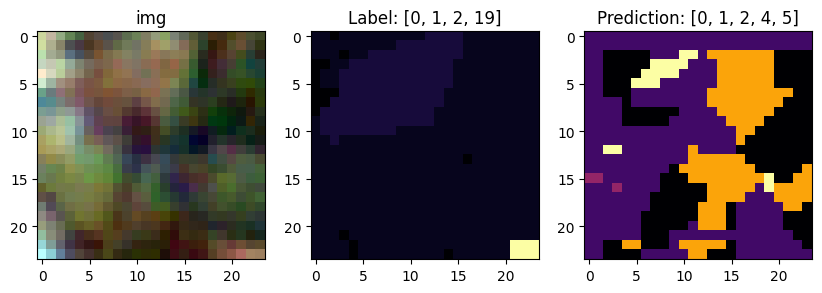

In [42]:
img, label = next(iter(dataset))
img = img.to(device)
output = inference(img)

fix, axes = plt.subplots(1,3, figsize=(10,10))
axes[0].imshow(get_rgb(img[0][:,:-1,:,:].cpu().numpy()))
axes[1].imshow(label[0].numpy(), cmap='inferno')
axes[2].imshow(output[0].cpu().numpy(), cmap='inferno')

axes[0].set_title('img')
axes[1].set_title(f'Label: {label[0].unique().tolist()}')
axes[2].set_title(f'Prediction: {output[0].int().cpu().unique().tolist()}')

In [43]:
output.shape

torch.Size([8, 24, 24])

In [44]:
label.shape

torch.Size([8, 24, 24])

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
output = torch.flatten(output)
label = torch.flatten(label)

In [47]:
accuracy_score(label, output)

0.2228732638888889

In [49]:
output

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [48]:
label

tensor([1, 1, 0,  ..., 1, 0, 2])